Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Enter a Metagenome file name, or enter 'f' for the foamy control or 's' for Swi: f
Do you want the standard CASM ('s') or without high-ammonia ASB ('w'): s
Do you want to change Wilcoxon and SD cutoff criteria? (y or n):  n

PLOT TYPES:

a, All points
b, Genera that meet both statistical criteria are plotted and labeled
c, Genera that meet Wilcoxon and by SD criteria are plotted and user-specified genera are labeled
Enter the Plot Type: b
Click on the plot icon when it appears, save it (if you wish), and then close it when you are done.

Wilcoxon outliers:
Verminephrobacter , -2.27348101882 , -2.579003833667952
Gramella , -2.43574540482 , -3.0604898937900646
Frankia , -2.2881074791 , -2.0978001567435616
Azoarcus , -2.29311211783 , -2.650010895709151
Ruegeria , -2.29920549232 , -2.6700722394472254
Desulfovibrio , -2.40831859553 , -3.0137464902477387
Comamon

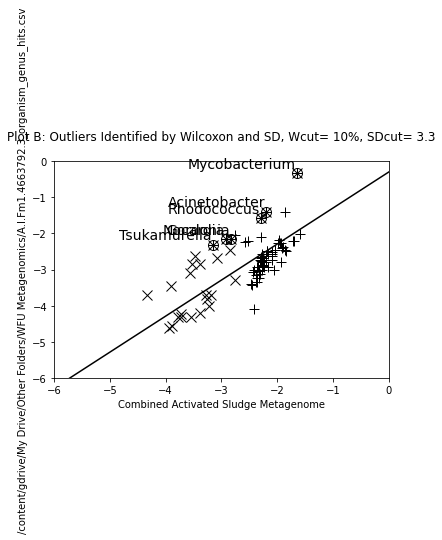

Mycobacterium,-1.64201024153,-0.3365970045115485
Acinetobacter,-2.20327279555,-1.4010106749530413
Dechloromonas,-1.85966450462,-1.4033229354349743
Rhodococcus,-2.29081547906,-1.5722526341649412
Streptomyces,-1.91963364528,-1.8455390634824582
Flavobacterium,-1.88215974254,-1.950019221860037
Acidovorax,-1.58487991589,-2.0194961930254536
Nitrospira,-2.74968054893,-2.034315811365275
Frankia,-2.2881074791,-2.0978001567435616
Gordonia,-2.83439337789,-2.1534424434438892
Nocardia,-2.92351870441,-2.160702542348207
Rhodobacter,-1.97535856029,-2.193695532281606
Corynebacterium,-2.52358987725,-2.200151887219071
Burkholderia,-1.70566848071,-2.2048667396685393
Pseudomonas,-1.72652710628,-2.2099426670811377
Nakamurella,-2.58181750522,-2.236581152845746
Rhodopseudomonas,-1.94958562453,-2.2523266803979403
Polaromonas,-1.93428992281,-2.273831665578071
Bradyrhizobium,-1.9777706925,-2.2754478139542464
Tsukamurella,-3.15538206129,-2.3116365211671033
Arthrobacter,-2.45487253058,-2.3443178593464236
Methylibi

In [3]:
"""PROGRAM THAT WILL COMPARE A METAGENOME TO A GLOBAL ACTIVATED SLUDGE 
METAGENOME. IT WILL CALCULATE GENERA FREQUENCIES FOR THE NEW METAGENOME, 
CALCULATE LOG-PROPORTIONS OF EACH GENUS FOR BOTH THE QUERY AND GLOBAL 
METAGENOMES, PERFORM WILCOXON AND VARIATION FROM STANDARD-DEVIATION ANALYSES.  
IT WILL THEN MAKE LOG-LOG PLOTS.  OUTPUT FILES INCLUDE THE FREQUENCY AND 
LOG-PROP DATA ("C" FILES), GENERA IDENTIFIED AS DEVIANT BY WILCOXON DATA IN 
"WX" FILES, AND SD DEVIANT GENERA IN "SD" FILES.  
"""
num_process = 500

import math
from matplotlib import pyplot
from numpy import arange
import bisect
from scipy import stats
import numpy as n
from google.colab import drive
drive.mount('/content/gdrive')
# Get the metagenome file. 'f' is for the Fm1 control database

print()
file_name1 = input("Enter a Metagenome file name, or enter 'f' for the foamy control or 's' for Swi: ")
if file_name1 in ('F','f'):
      file_name1 = "/content/gdrive/My Drive/Other Folders/WFU Metagenomics/A.I.Fm1.4663792.3_organism_genus_hits.csv"
elif file_name1 in ('s', 'S'):
      file_name1 = "/content/gdrive/My Drive/Other Folders/WFU Metagenomics/A.e.Switzerland.4568625.3_organism_genus_hits.csv"
work_file1 = open(file_name1, 'r')

# Get the Combined Activated Sludge Metagenome file:

got_casm = False
while got_casm == False:
      print
      mg_type = input("Do you want the standard CASM ('s') or without high-ammonia ASB ('w'): ")
      if mg_type in ('s', 'S'):
            file_name2 = "/content/gdrive/My Drive/Other Folders/WFU Metagenomics/MGIT.A_H.Ex.C.500.Genera.Freq.csv" 
            got_casm = True
            x_title = "Combined Activated Sludge Metagenome"
      elif mg_type in ('w', 'W'):
            file_name2 = "/content/gdrive/My Drive/Other Folders/WFU Metagenomics/MGIT.A_H.Ex.EC.500.Genera.Freq.csv"
            got_casm = True
            x_title = "Combined Activated Sludge Metagenome Without Swi" 
      else: 
            print()
            print( "Please enter 's' or 'w' ")
            continue
work_file2 = open(file_name2, 'r')

# Get Wilcoxon and Standard Deviation cut-offs.  
print
got_cuts = False
while got_cuts == False:
   cuts = input("Do you want to change Wilcoxon and SD cutoff criteria? (y or n):  ")
   if cuts in ('N','n'):
      w_cutoff = 10
      sd_cut = 3.3
      got_cuts = True
   elif cuts in ('Y','y'):
      got_w_cutoff = False
      print()
      while got_w_cutoff == False:
         raw_w_cutoff = input("Enter a Wilcoxon cutoff at a top %. The default is '10':  ")
         try:
            w_cutoff = float(raw_w_cutoff)
            got_w_cutoff = True
         except:
            print("Enter the Wilcoxon cutoff as a number between 1 and 100.  ")
      got_SD_cutoff = False
      print()
      while got_SD_cutoff == False:
         raw_SD_cutoff = input("Enter a SD cutoff. The default is '3.3':  ")
         try:
            sd_cut = float(raw_SD_cutoff)
            got_SD_cutoff = True
         except:
            print("Enter the SD cutoff as a number.  ")         
      got_cuts = True  
print()                  
 
# Minimum number of MGs cutoff in the global set that have a given genus to be \
# in least variability plots
min_num_match = 3  

#4. Routine for selecting PLOT TYPE using 'raw_input' from the console:
print( 'PLOT TYPES:')
print()
print( "a, All points")
#print( "b, Just the points with freq > " +str(sd_cut)+ " SD from global average freq")
#print( "c, Just the Wilcoxon top " +str(w_cutoff)+ "%")
print( "b, Genera that meet both statistical criteria are plotted and labeled")
print( "c, Genera that meet Wilcoxon and by SD criteria are plotted and user-specified genera are labeled")

got_plot = False
while got_plot == False:
   plot_select = input("Enter the Plot Type: ")
   plot_type = plot_select.upper()
   if plot_type in ('A', 'B', 'C'):
      got_plot = True
      print( 'Click on the plot icon when it appears, save it (if you wish), and then close it when you are done.' )
      print()
   else:
      print()
      print( "Oops!  Enter a plot type as a letter from 'a' to 'c' ")
      print()

if plot_type == 'C' :  
   print()
   got_taxa = False
   while got_taxa == False:
      keywords = input("Enter each taxon name, separated by commas: ")
      try:
         keys = keywords.replace(" ","")    
         keys = keys.replace("'","")
         key_list = keys.split(',')
         key_num = len(key_list)
         print( key_list) 
         got_taxa = True
      except:
         print( "Oops! Enter names separated by commas." )
         continue

# this routine will capture hit data as floats.
def flt_NA (x):  
   try:
      return float(x)
   except:
      return 0

def clean_data(s):
   t = s.replace('\"','') # remove superfluous double-quotes
   return t.strip() # remove whitespace at beginning and end
    
#this next section gets the file sizes
num_lines1 =0
num_lines2 =0
with open (file_name1,'rb') as f:
   for line in f:
      num_lines1 +=1
if num_lines1 < 500:
   num_process = num_lines1

with open (file_name2,'rb') as f:
   for line in f:
      num_lines2 +=1

#gets total hits in the first sample database for frequency calculations
database_hits1 =0.0
work_file1.seek(0)
for count1 in range(0, num_process):
    work_line1 = work_file1.readline().strip('\n').strip('\r')
    taxon1, num_hits1 = work_line1.split(',')
    database_hits1 = database_hits1 + float(num_hits1)

#HERE IS THE FIRST LOOP
num_func1 =0
count1 =0
count2 =0
num_taxon1 =0
taxon_list =[]
out_list =[]
work_file1.seek(0)
for count1 in range(0, int(num_process)):  
   duplicate = True
   hit = False
   work_line1 = work_file1.readline().strip('\n').strip('\r')  
   try:
      taxon1, num_hits1 = work_line1.split(',')
   except:
      print( "The file must be a 'csv' file with two columns: Genus names, numbers")
   freq1 =  flt_NA(num_hits1) / database_hits1
   if taxon1 not in taxon_list:
      duplicate = False
      taxon_list.append(taxon1)
      num_taxon1 +=1
      count2 = 0
      if freq1 >= 0.000001:
         log_prop1 = math.log(freq1, 10)
      elif freq1 < 0.000001:
         log_prop1 = -6
      out_line = [clean_data(taxon1), freq1, 0, log_prop1, -6, 0, 1, 0]
      hit = False
      work_file2.seek(0)
      for count2 in range(0, num_lines2):  
         work_line2 = work_file2.readline().strip('\n').strip('\r')
         taxon2, freq2, rel_err, num_match, log_prop2, std_dev = work_line2.split(',')
         if taxon1 == taxon2:
            hit = True
            out_line[2] = flt_NA(freq2) /1000 
            out_line[4] = flt_NA(log_prop2)
            out_line[5] = flt_NA(rel_err) /1000 
            out_line[6] = int(num_match)
            out_line[7] = flt_NA(std_dev) /1000
             
      if duplicate == False:
            out_list.append(out_line)
      elif duplicate == True:
            pass
     
#HERE IS THE SECOND LOOP
work_file2.seek(0)
num_taxon2 =0
for count2 in range(0, num_lines2):  
   duplicate = False
   hit = False
   work_line2 = work_file2.readline().strip('\n').strip('\r')  
   taxon2, str_freq2, str_rel_err, num_match, str_log_prop2, std_dev = work_line2.split(',')
   if taxon2 in taxon_list:
      duplicate = True
   if duplicate == False:
      taxon_list.append(taxon2)
      num_taxon2 +=1
      out_line = [clean_data(taxon2), 0, flt_NA(str_freq2)/1000, -6, flt_NA(str_log_prop2), flt_NA(str_rel_err)/1000, int(num_match), flt_NA(std_dev)/1000]
      count1 = 0
      hit = False
      work_file1.seek(0)
      for count1 in range(0, num_lines1):  
         work_line1 = work_file1.readline().strip('\n').strip('\r')
         taxon1, num_hits1 = work_line1.split(',')
         hit = False
         if taxon1 == taxon2:
            hit = True
            if hit == True:
               freq1 = flt_NA(num_hits1) / database_hits1
               log_prop1 = math.log(freq1, 10) 
               out_line[1] = freq1 
               out_line[3] = log_prop1

      if duplicate == False:
            out_list.append(out_line) 
      elif duplicate == True:
            pass

"""
CALCULATIONS FOR THE WILCOXON SIGNED RANK TEST AND FOR THE BRAY-CURTIS
DISIMILARITY INDEX
"""

#Main
count1 =0
BC_min_sum =0.0
BC_both_sum =0.0
BC_diff =0.0
w_list = []
for count1 in range(0, len(out_list)):  
   if float(out_list[count1][1] + float(out_list[count1][2]) >0):
      diff = (out_list[count1][1]) - (out_list[count1][2])
      abso = abs(diff)
      BC_diff = BC_diff + abso
      BC_both_sum =  BC_both_sum + out_list[count1][1] + out_list[count1][2]
      if out_list[count1][1] >= out_list[count1][2]:
         sign = 1
      elif out_list[count1][1] < out_list[count1][2]:
         sign = -1  

      w_sort = [ out_list[count1][0], diff, sign, float(abso), out_list[count1][3], out_list[count1][4], \
                out_list[count1][6], out_list[count1][7] ]
      w_list.append(w_sort)

w_list.sort(key=lambda x: float(x[3]))

Bray_Curtis = BC_diff / BC_both_sum

num_ranks = len(w_list)
w_sum =0.0
for count2 in range(0,num_ranks):
    sign_rank = w_list[count2][2] * (count2+ 1)
    w_sum = w_sum + sign_rank

w_variance = num_ranks * (num_ranks +1) * (2 * num_ranks +1) / 6
w_sd = math.sqrt(w_variance)

if abs(w_sum) > 2 * w_sd:
    reject = ' No, they are different.'
elif abs(w_sum) <= 2 * w_sd:
    reject = ' Yes, they are similar. '

#Routines for plotting LogProp data.

# this routine fills out the data frame as a 'list of lists' (array of row):
array =[]
for count1 in range(0, num_ranks):
      if w_list[count1][6] >= min_num_match: 
            array.append(w_list[count1])
    
#  adjust plotting parameters (x and y limits, axes labels, etc.):


#calculates best-fir line
bfx =[]
bfy =[]
for a in range(0, len(array)):
      if array[a][5] > -5 and array[a][4] > -5:
            bfx.append(array[a][5])
            bfy.append(array[a][4])
slope, intercept, r_value, p_value, std_err = stats.linregress(bfx,bfy)

z = ''
def scatterplot_open(x,y,kwargs):
    pyplot.plot(m,n,'k+', p,q,'kx', r,s,'ko',markersize= '10', fillstyle='none')
    pyplot.xlim(-6,0)
    pyplot.ylim(-6,0)
    pyplot.xlabel(x_title)
    pyplot.ylabel(file_name1)
    pyplot.title(plot_title)
    
def scatterplot_bestline(x,y,kwargs):
    pyplot.plot(x,y,z)
  
def label_plot1(x,y,z):
   labels = [coords[i][0][:] for i in range(0, len(coords))]
   for label in range(len(coords)):
       if coords[label][1] < coords[label][2]:
            pyplot.annotate(coords[label][0][:], xy = (coords[label][1], coords[label][2]), xytext =  \
                       (-1, 2), textcoords = 'offset points', va='bottom', ha='right', fontsize=14)
       elif coords[label][1] >= coords[label][2]:
            pyplot.annotate(coords[label][0][:], xy = (coords[label][1], coords[label][2]), xytext =  \
                       (1, -3), textcoords = 'offset points', va='top', ha='left', fontsize=14)         
m =[]
n =[]
p =[]
q =[]
r =[]
s =[]
x =[]
y =[]

# THE PLOTTING ROUTINES:
#scatterplot_bestline(x,y,'k-')
bestline_x = [0, -6]
bestline_y = [intercept, -6* slope]
z = 'k-'
scatterplot_bestline(bestline_x, bestline_y, z)    
    
if plot_type == 'A' : #all points in blue'
    plot_title = 'Plot A: Log10 Frequencies of All Genera \n' 
    for a in range(0, len(array)):
        m.append(array[a][5])
        n.append(array[a][4])
    scatterplot_open(m,n,z) 
    
"""
if plot_type == 'B' : #SD beyond cutoff as 'bx'
    sd_more =0
    sd_less =0
    plot_title = 'Plot B: Outliers Identified by the SD, SDcut= '+str(sd_cut)+ '\n'
    print 'SD outliers:'
    for b in range(0, len(array)):
        if array[b][3] >=  array[b][7] * sd_cut: 
            p.append(array[b][5])
            q.append(array[b][4])
            print array[b][0], ',', array[b][5], ',', array[b][4]
            if array[b][1] >0:
                sd_more +=1
            elif array[b][1] <0:
                sd_less +=1
    scatterplot_open(q,p,z) 

if plot_type == 'C' : #Wilcoxon beyond cutoff as 'b+'
    plot_title = 'Plot C: Outliers Identified by the Wilcoxon, Wcut= '+str(w_cutoff)+ '\n'
    print 'Wilcoxon outliers:'
    for a in range(int(len(array) - len(array) * w_cutoff * 0.01), len(array)):
        m.append(array[a][5])
        n.append(array[a][4])
        print array[a][0], ',', array[a][5], ',', array[a][4]
    scatterplot_open(x,y,z) 
"""
if plot_type == 'C' : #SD as 'bx', Wilcoxon as 'b+' and genera as 'ro'
   coords =[]
   plot_title = 'Plot C: Outliers Identified by Wilcoxon and SD, Wcut= '+str(w_cutoff)+ '%, SDcut= ' +str(sd_cut)+ '\n' 
   sd_more =0
   sd_less =0 
   print( "Wilcoxon outliers:")
   for a in range(int(len(array) - len(array) * w_cutoff * 0.01), len(array)):
      m.append(array[a][5])
      n.append(array[a][4])
      print(array[a][0], ',', array[a][5], ',', array[a][4])
   print()
   print( "SD outliers:")
   for b in range(0, len(array)):
      if array[b][3] >=  array[b][7] * sd_cut: 
          p.append(array[b][5])
          q.append(array[b][4])
          print( array[b][0], ',', array[b][5], ',', array[b][4] )
          if array[b][1] >0:
              sd_more +=1
          elif array[b][1] <0:
              sd_less +=1
   for c in range(0, len(array)):
         genus = array[c][0].replace('Candidatus ', '') 
         if genus in  key_list:  
              r.append(array[c][5])
              s.append(array[c][4])
              coords.append([array[c][0].replace('unclassified (derived from ', '').replace(')', ''), array[c][5], array[c][4]])
   scatterplot_open(x,y,z) 
   label_plot1(x,y,z)

if plot_type == 'B' : #SD as 'bx', Wilcoxon as 'b+' and genera as 'ro'
   coords =[]
   plot_title = 'Plot B: Outliers Identified by Wilcoxon and SD, Wcut= '+str(w_cutoff)+ '%, SDcut= ' +str(sd_cut)+ '\n' 

   sd_more =0
   sd_less =0 
   w_genus =[]
   print( "Wilcoxon outliers:")
   for a in range(int(len(array) - len(array) * w_cutoff * 0.01), len(array)):
      m.append(array[a][5])
      n.append(array[a][4])
      print( array[a][0], ',', array[a][5], ',', array[a][4])
      w_genus.append(array[a][0])
   print()   
   print( "SD outliers:")   
   for b in range(0, len(array)):
      if array[b][3] >=  array[b][7] * sd_cut: 
          p.append(array[b][5])
          q.append(array[b][4])
          print( array[b][0], ',', array[b][5], ',', array[b][4] )
          if array[b][1] >0:     
              sd_more +=1
          elif array[b][1] <0:
              sd_less +=1
          if array[b][0] in w_genus:      
              r.append(array[b][5])
              s.append(array[b][4])
              coords.append([array[b][0].replace('unclassified (derived from ', '').replace(')', '').replace('Candidatus ', '') \
                             , array[b][5], array[b][4]])
   scatterplot_open(x,y,z) 
   label_plot1(x,y,z) 

pyplot.show()

file_name3 = file_name1.replace('csv', 'POINTS.csv')
work_file3 = open(file_name3, 'w')
for line in range(0, len(out_list)):
      print (str(out_list[line][0]) + ',' + str(out_list[line][4]) + ',' + str(out_list[line][3])) 
      work_file3.write(str(out_list[line][0]) + ',' + str(out_list[line][4]) + ',' + str(out_list[line][3]) + '\n')
                       
work_file1.close()
work_file2.close()
work_file3.close()                               

print()
print( "Slope =", str(slope)[:5], ", intercept =", str(intercept)[:5], ", r^2 =", str(r_value**2)[:5])
print()
print( "Bray Curtis Dissimilarity Index =" +str(Bray_Curtis)[:5])
print()
print("Done!")
